<a href="https://colab.research.google.com/github/mazenmagdii/VGG16-Covid-19-Image-Dataset/blob/main/VGG16_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print(f"File {fn} was uploaded")

!mkdir -p ~/.kaggle && mv kagle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
File kaggle (1).json was uploaded
mv: cannot stat 'kagle.json': No such file or directory


In [ ]:
!kaggle datasets download -d pranavraikokte/covid19-image-dataset

Dataset URL: https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset
License(s): CC-BY-SA-4.0
covid19-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile
file_path = "/content/covid19-image-dataset.zip"
with ZipFile(file_path, 'r') as zip_file:
  zip_file.extractall()
  print('Extraction Compelted')

Extraction Compelted


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense,Flatten,Dropout,GlobalAveragePooling2D,Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
np.random.seed(101)
tf.random.set_seed(101)

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)


train_datagen = ImageDataGenerator(rescale = 1./255)


In [ ]:
train_dir = "/content/Covid19-dataset/train"
test_dir = "/content/Covid19-dataset/test"
Height=224
Width=224
Batchsize=32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(Height, Width),
    batch_size=Batchsize,
    class_mode='sparse',
    shuffle=True,
    classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(Height, Width),
    batch_size=Batchsize,
    class_mode='sparse',
    shuffle=False,
    classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )


Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [ ]:
t_image = np.concatenate([train_generator.labels,test_generator.labels])

In [ ]:
print('Normal_cases: ',len(np.where(t_image==0)[0]))
print('Viral_Pneumonia_cases: ',len(np.where(t_image==1)[0]))
print('Covid_cases: ',len(np.where(t_image==2)[0]))

Normal_cases:  90
Viral_Pneumonia_cases:  90
Covid_cases:  137


In [ ]:
images, labels = next(train_generator)

In [ ]:
def plot_images(images_arr, labels_arr, class_indices):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        label = list(class_indices.keys())[list(class_indices.values()).index(int(lbl))]
        ax.set_title(label)
    plt.tight_layout()
    plt.show()

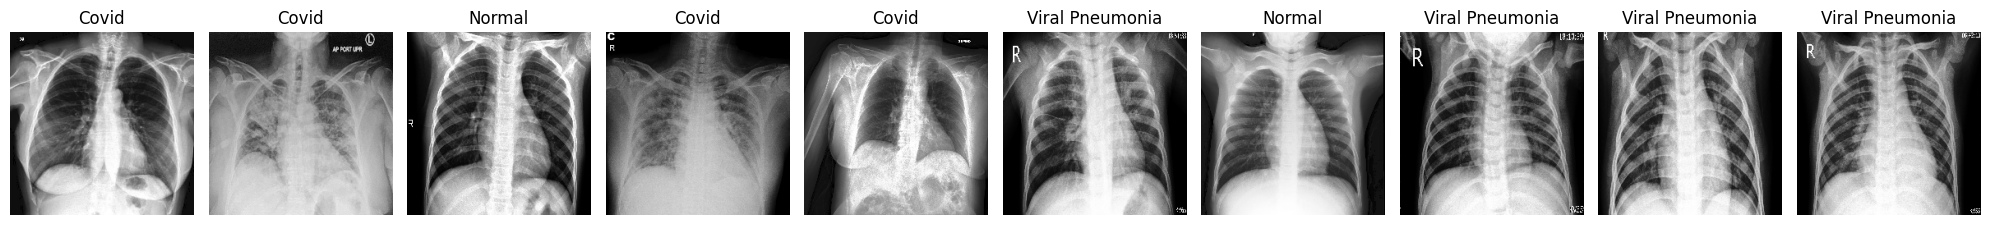

In [ ]:
plot_images(images[:10], labels[:10], train_generator.class_indices)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(Height, Width, 3))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
num_classes = len(train_generator.class_indices)
print('Number of classes:', num_classes)

Number of classes: 3


In [ ]:
model = Sequential([
    Input(shape=(Height, Width, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.5),
    Dense(256,activation='relu'),
    Dropout(0.5),
    Dense(num_classes,activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,912,579 (56.89 MB)

 Trainable params: 197,891 (773.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

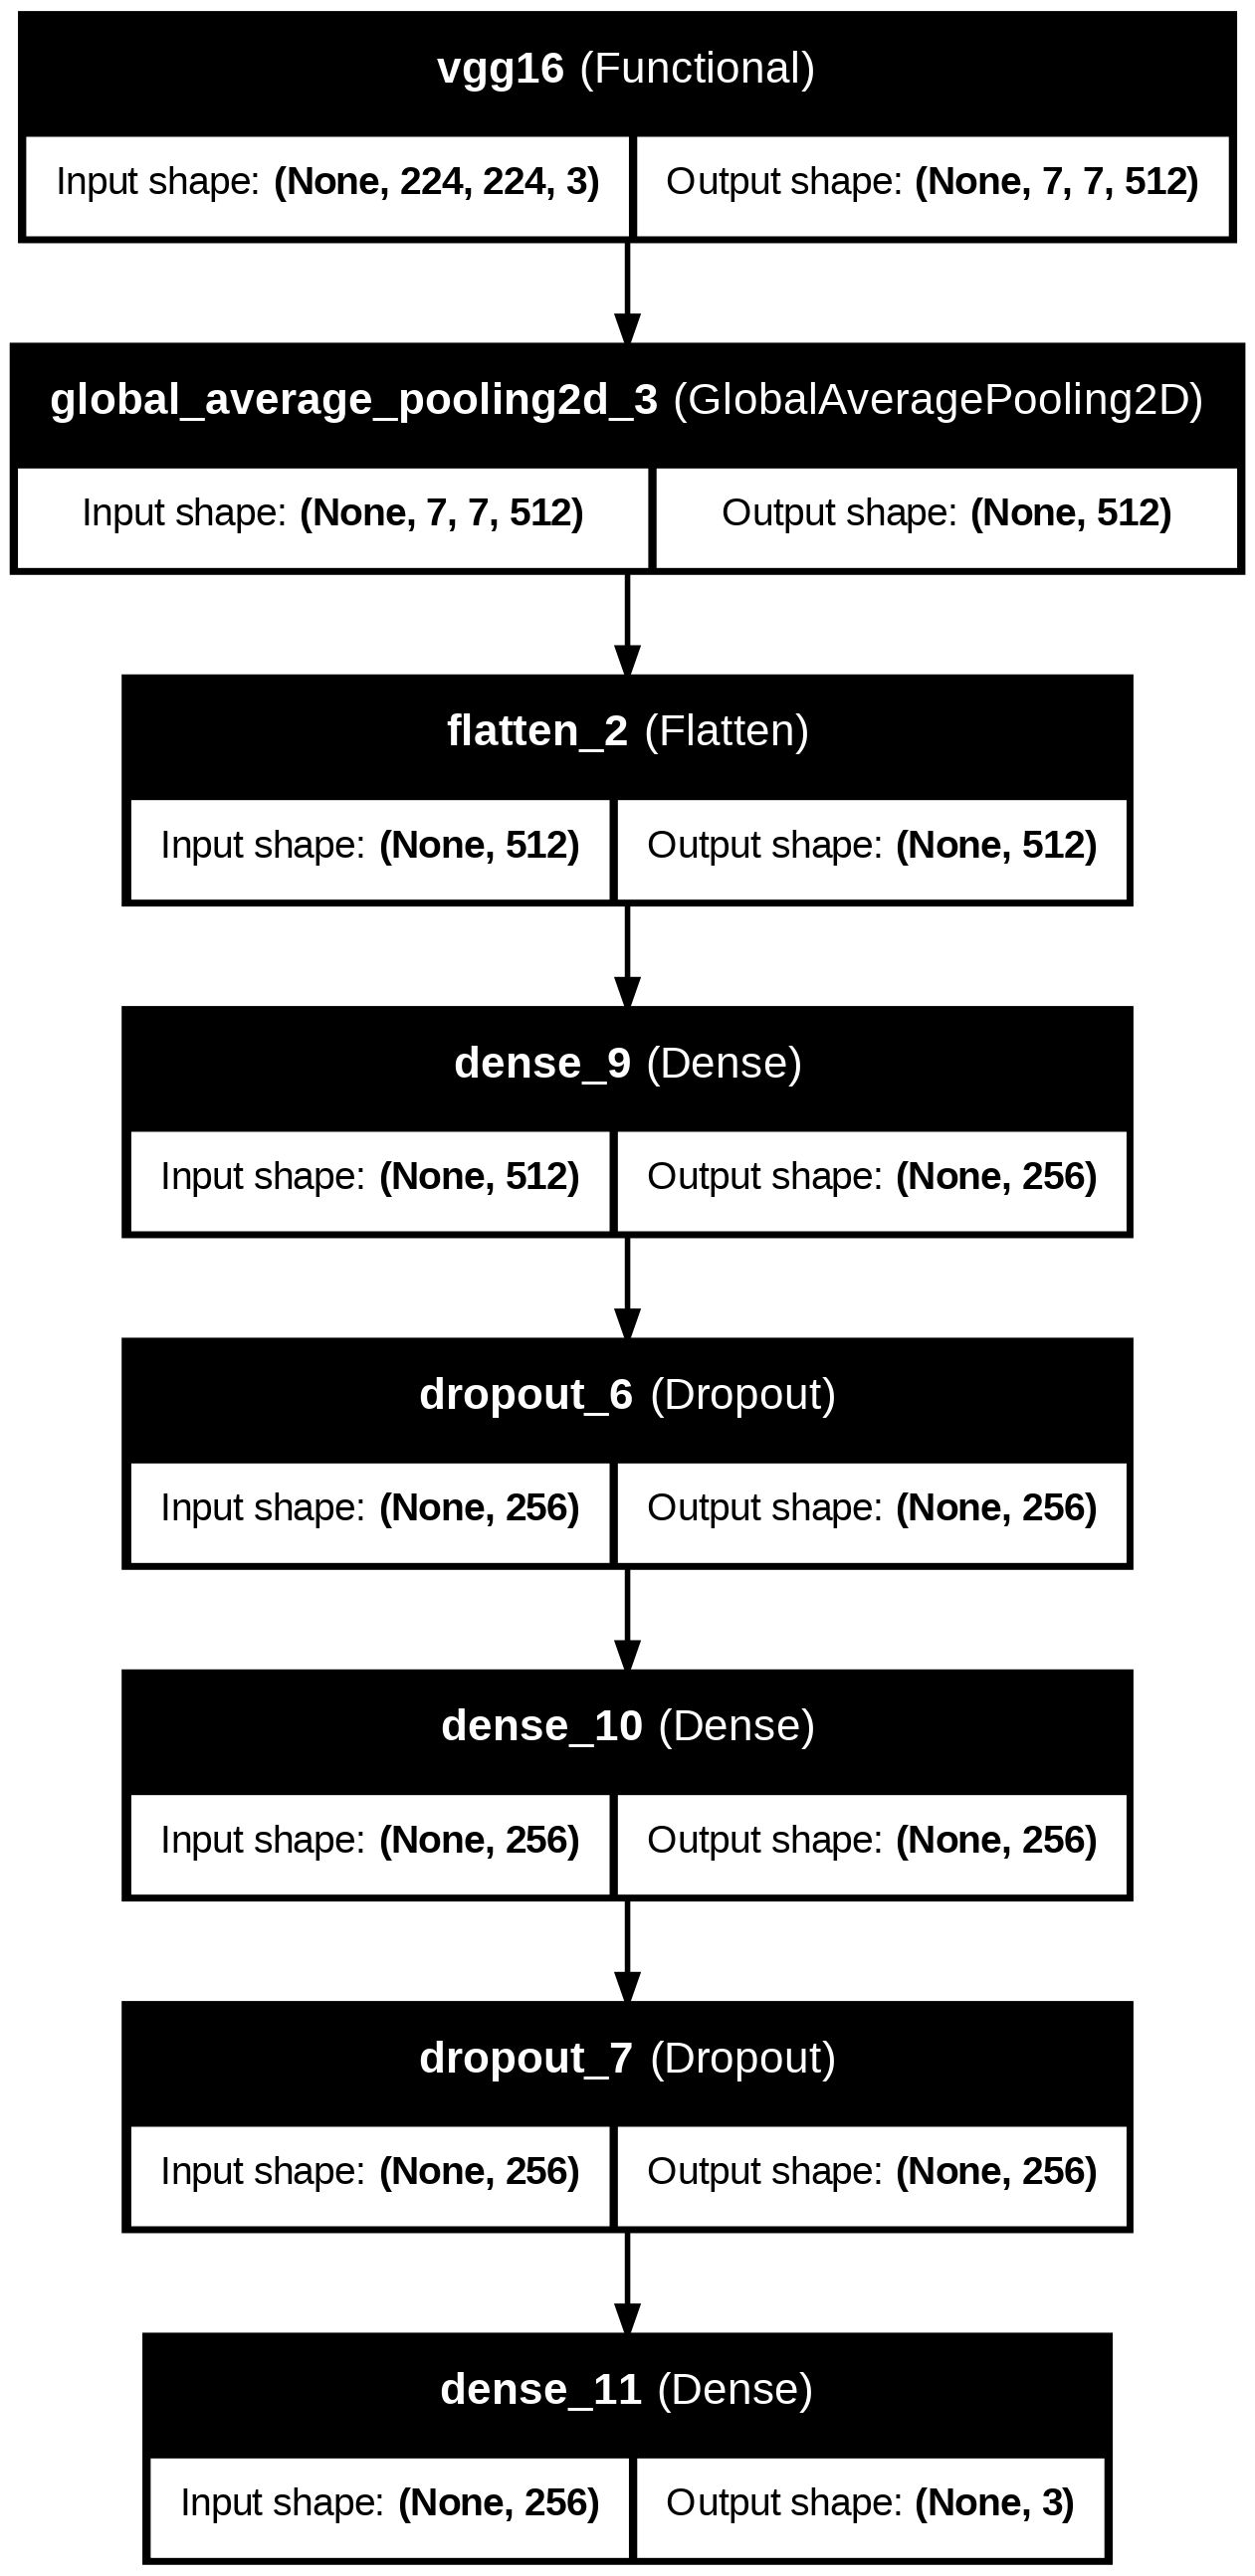

In [ ]:
tf.keras.utils.plot_model(model, to_file='vgg16-image-classifier.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0009),
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint('vgg16_best_weights.keras',
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max',
                             save_best_only=True)

early = EarlyStopping(monitor="val_loss",
                      min_delta=0.01,
                      mode="min",
                      restore_best_weights=True,
                      patience=5)

callbacks_list = [checkpoint,early]

In [ ]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[callbacks_list],
    verbose=True,
    shuffle=True)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.3652 - loss: 1.2125
Epoch 1: val_accuracy improved from -inf to 0.39394, saving model to vgg16_best_weights.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 785ms/step - accuracy: 0.3689 - loss: 1.2079 - val_accuracy: 0.3939 - val_loss: 1.0529
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.4714 - loss: 1.0531
Epoch 2: val_accuracy improved from 0.39394 to 0.75758, saving model to vgg16_best_weights.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms/step - accuracy: 0.4722 - loss: 1.0539 - val_accuracy: 0.7576 - val_loss: 0.8967
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.4778 - loss: 1.0344
Epoch 3: val_accuracy did not improve from 0.75758
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step - accuracy: 0.4783 - loss: 1.0316 - val_accuracy: 0.7424 - val_loss: 0.7912
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5899 - loss: 0.8564
Epoch 4: val_accuracy improved from 0.75758 to 0.78788, saving model to vgg1

In [ ]:
model.save('vgg16_complete_model.h5')

In [ ]:
def plot_learning_curve(history, metrics):
    acc = history.history[metrics]
    val_acc = history.history[f'val_{metrics}']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(5,3))
    plt.plot(epochs, acc, label=f'training {metrics}')
    plt.plot(epochs, val_acc, label=f'validation {metrics}')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.legend()

    plt.figure(figsize=(5,3))
    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

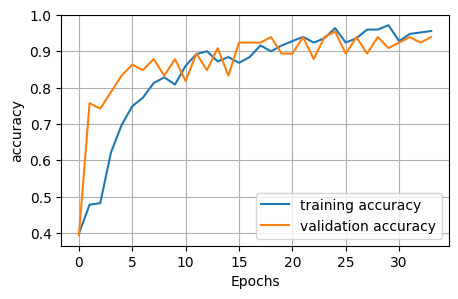

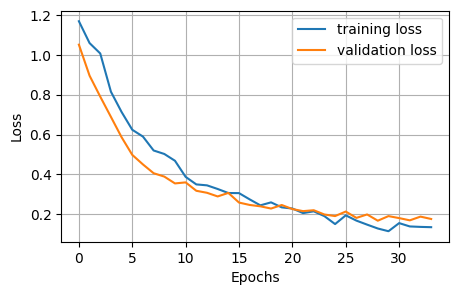

In [ ]:
plot_learning_curve(history, metrics='accuracy')

In [ ]:
train_result = model.evaluate(train_generator)
test_result = model.evaluate(test_generator)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 559ms/step - accuracy: 0.9639 - loss: 0.1007
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9384 - loss: 0.1849


In [ ]:
print(f"Train Loss: {np.round(train_result[0], 4)}")
print(f"Test Loss: {np.round(test_result[0], 4)}")
print(f"Train Accuracy: {np.round(train_result[1]*100, 2)}%")
print(f"Test Accuracy: {np.round(test_result[1]*100, 2)}%")

Train Loss: 0.0974
Test Loss: 0.1665
Train Accuracy: 96.81%
Test Accuracy: 93.94%


In [ ]:
y_pred_p = model.predict(test_generator)
print(y_pred_p.shape)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step
(66, 3)


In [ ]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int32)

In [ ]:
print('Normal_cases: ',len(np.where(y_true==0)[0]))
print('Viral_Pneumonia_cases: ',len(np.where(y_true==1)[0]))
print('Covid_cases: ',len(np.where(y_true==2)[0]))

Normal_cases:  20
Viral_Pneumonia_cases:  20
Covid_cases:  26


In [ ]:
y_pred_p = model.predict(test_generator)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step


In [ ]:
classes_names = list(test_generator.class_indices.keys())

In [ ]:
y_pred = np.argmax(y_pred_p, axis=1)

confusion = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", confusion)

p_confusion = confusion_matrix(y_true, y_true)
print("Perfect Confusion Matrix:\n", p_confusion)

report = classification_report(y_true, y_pred, target_names=classes_names)
print("\nClassification Report:\n", report)

Confusion Matrix:
 [[19  1  0]
 [ 3 17  0]
 [ 0  0 26]]
Perfect Confusion Matrix:
 [[20  0  0]
 [ 0 20  0]
 [ 0  0 26]]

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.86      0.95      0.90        20
Viral Pneumonia       0.94      0.85      0.89        20
          Covid       1.00      1.00      1.00        26

       accuracy                           0.94        66
      macro avg       0.94      0.93      0.93        66
   weighted avg       0.94      0.94      0.94        66



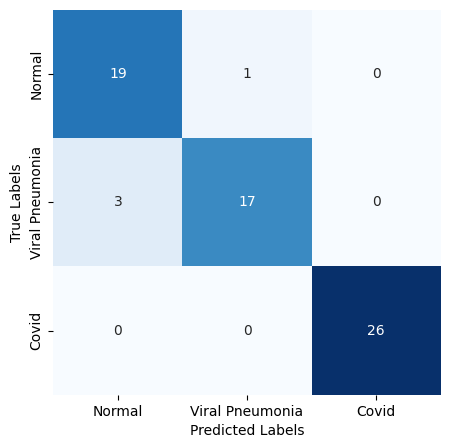

In [ ]:
plt.figure(figsize=(5, 5))
hmap = sns.heatmap(confusion, annot=True, vmin=0,
                 fmt='g', cmap='Blues', cbar=False,
                 xticklabels=classes_names,
                 yticklabels=classes_names)

hmap.set(xlabel='Predicted Labels')
hmap.set(ylabel='True Labels')
plt.show()

In [ ]:
#Extract wrong classification index
wrong_pred = np.where(y_pred!=y_true)[0]
print(f'Total of {len(wrong_pred)} missclassified images')
print('Missclassified images index: ',wrong_pred)

Total of 4 missclassified images
Missclassified images index:  [ 7 28 34 37]
